# Fitting the basic model on Linux dataset

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import tensorflow as tf
import math
import os
import matplotlib.pyplot as plt
import numpy as np

from interank import linuxutils
from interank.models import BasicModel
from interank.linuxdata import LinuxData
from datetime import datetime as dt
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, average_precision_score

summaries_dir = '../trained-models/log-dir/'

## Load dataset

In [2]:
%%time
dataset = LinuxData("/data/datasets/linux")

train = dataset.get_train_data()
test = dataset.get_test_data()

print("Training set: {} edits".format(len(train[0])))
print("Test set: {} edits".format(len(test[0])))
print("Number of users: {}".format(dataset.n_users))
print("Number of articles: {}".format(dataset.n_subsystems))
print("––––––––––")

Training set: 495536 edits
Test set: 123883 edits
Number of users: 9672
Number of articles: 394
––––––––––
CPU times: user 1.32 s, sys: 68 ms, total: 1.38 s
Wall time: 1.35 s


## Tensorflow configuration

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
# Reset graph to run the notebook twice in a row without error 
tf.reset_default_graph()

# Number of latent factors for the MF term

# Basic model
model = BasicModel(n_users=dataset.n_users,
                   n_articles=dataset.n_subsystems,
                   global_bias=True)

# Setup the optimisation procedure
minibatch_size = 2000
minibatch_size_tf = tf.Variable(minibatch_size, trainable=False)
num_batches = math.ceil(len(train[0]) / minibatch_size)
epochs = 50

# Define the cost
reg_coeff = 16
cost = -model.log_likelihood + (reg_coeff / num_batches) * (model.l2_skill + model.l2_difficulty)

# Setup optimiser
learning_rate = 0.1

# Decaying learning rate
# decay_rate = 0.9
# global_step = 0
# Decaying learning rate
# batch_idx = tf.Variable(0, trainable=False)
# learning_rate_tf = tf.train.exponential_decay(
#     learning_rate=learning_rate,
#     global_step=(batch_idx * minibatch_size),
#     decay_steps=len(train[0]),
#     decay_rate=decay_rate,
#     staircase=True
# )
# train_step = tf.train.GradientDescentOptimizer(learning_rate_tf).minimize(cost, global_step=batch_idx)

# Adagrad
learning_rate_tf = tf.Variable(learning_rate, dtype=tf.float32)
train_step = tf.train.AdagradOptimizer(learning_rate_tf).minimize(cost)

# Summaries for Tensorboard
auc_ph = tf.placeholder(tf.float32, name="auc")
tf.summary.scalar("avg_log_loss", model.avg_log_loss)
tf.summary.scalar("area_under_pr_curve", auc_ph)
tf.summary.scalar("learning_rate", learning_rate_tf)
merged = tf.summary.merge_all()
    
log = 'tuned/optimization_{}_epochs_{}_minibatchsize_{}__learningrate_{}_date_{}'.format(
    'Adagrad',
    epochs,
    minibatch_size,
    learning_rate,
    dt.now().strftime('%Y-%m-%d-%H-%M-%S')
)
train_writer = tf.summary.FileWriter(summaries_dir + '/' + log + '/train')
test_writer = tf.summary.FileWriter(summaries_dir + '/' + log + '/test')

## Train the model

In [5]:
%%time
feed_test = {
    model.user_id: test[0],
    model.article_id: test[1],
    model.quality: test[2],
}

# Keep track of likelihood
test_likelihood = [-np.inf]

print('Total number of batches: {}'.format(num_batches))

def evaluate(session, step):
    avg_log_loss, probs, bias = session.run(
            [model.avg_log_loss, model.probability, model.global_bias], feed_dict=feed_test)
    
    labels = feed_test[model.quality].astype(int)
    auc = average_precision_score(labels, probs)
    
    summary = session.run(merged, feed_dict={**feed_test, auc_ph: auc})
    
    test_writer.add_summary(summary, global_step=step)
    test_writer.flush()
    
    return avg_log_loss, auc, bias
    

# Initialise Tensorflow's variables
session = tf.Session()
session.run(tf.global_variables_initializer())

with session.as_default():
    step = 0

    avg_log_loss, auc, bias = evaluate(session, step)
    print('Epoch 0 - avg. log-loss = {:.6f}, AUC = {:.3f}, bias = {}'
          .format(avg_log_loss, auc, bias))

    for i in range(epochs):
        # Train the model on minibatch
        for j, minibatch in enumerate(LinuxData.minibatches(train, minibatch_size)):
            step += 1
            feed_dict = {
                model.user_id: minibatch[0],
                model.article_id: minibatch[1],
                model.quality: minibatch[2],
            }
            _ = session.run([train_step], feed_dict=feed_dict)

        avg_log_loss, auc, bias = evaluate(session, step)
        print('Epoch {} - avg. log-loss = {:.6f}, AUC = {:.3f}, bias = {}'
              .format(i + 1, avg_log_loss, auc, bias))

Total number of batches: 248
Epoch 0 - avg. log-loss = 0.693147, AUC = 0.333, bias = 0.0
Epoch 1 - avg. log-loss = 0.589445, AUC = 0.519, bias = -0.3999224305152893
Epoch 2 - avg. log-loss = 0.589655, AUC = 0.522, bias = -0.3939407169818878
Epoch 3 - avg. log-loss = 0.589936, AUC = 0.523, bias = -0.3933514654636383
Epoch 4 - avg. log-loss = 0.589073, AUC = 0.524, bias = -0.4095945954322815
Epoch 5 - avg. log-loss = 0.589548, AUC = 0.524, bias = -0.4052961766719818
Epoch 6 - avg. log-loss = 0.588975, AUC = 0.525, bias = -0.4175031781196594
Epoch 7 - avg. log-loss = 0.588711, AUC = 0.525, bias = -0.4264986515045166
Epoch 8 - avg. log-loss = 0.589274, AUC = 0.524, bias = -0.419694721698761
Epoch 9 - avg. log-loss = 0.589276, AUC = 0.525, bias = -0.4243673086166382
Epoch 10 - avg. log-loss = 0.589245, AUC = 0.525, bias = -0.42806893587112427
Epoch 11 - avg. log-loss = 0.588880, AUC = 0.525, bias = -0.4363716244697571
Epoch 12 - avg. log-loss = 0.589130, AUC = 0.525, bias = -0.4337504208087

## Evaluate

In [6]:
with session.as_default():
    probs = session.run(
            [model.probability], feed_dict=feed_test)

### Precision-recall curve

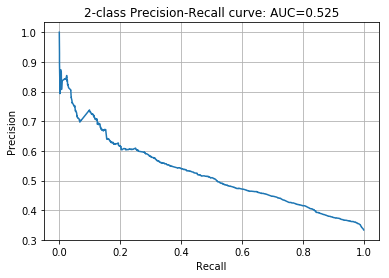

In [7]:
target = np.array([np.float32(t) for t in test[2]]).squeeze()
predictions = np.array(probs).squeeze()

average_precision = average_precision_score(target, predictions)
precision, recall, _ = precision_recall_curve(target, predictions)

plt.plot(recall, precision)

plt.grid()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('2-class Precision-Recall curve: AUC={0:0.3f}'.format(
          average_precision))
plt.show()

## Qualitative results

In [8]:
with session.as_default():
    skills = model.skill.eval()
    difficulties = model.difficulty.eval()
subsystems = dataset.get_subsystems()
users = dataset.get_users()

In [9]:
linuxutils.print_subsystems_summary(difficulties, subsystems, n=10)

### 10 most difficult subsystems:
 1 +2.252 usr (796 patches, 70 users)
    rate: 1.8844%, main contributor: fujita.tomonori@lab.ntt.co.jp
 2 +1.101 include (398 patches, 101 users)
    rate: 7.7889%, main contributor: plagnioj@jcrosoft.com
 3 +0.968 lib (5642 patches, 707 users)
    rate: 15.9872%, main contributor: torvalds@linux-foundation.org
 4 +0.792 tools (9985 patches, 400 users)
    rate: 19.9800%, main contributor: acme@ghostprotocols.net
 5 +0.749 include/trace (547 patches, 81 users)
    rate: 17.7331%, main contributor: rostedt@goodmis.org
 6 +0.716 drivers/md (4800 patches, 276 users)
    rate: 25.6042%, main contributor: neilb@suse.de
 7 +0.706 drivers/clk (495 patches, 81 users)
    rate: 34.3434%, main contributor: viresh.kumar@st.com
 8 +0.681 fs (9421 patches, 713 users)
    rate: 18.1934%, main contributor: torvalds@linux-foundation.org
 9 +0.638 net/batman-adv (600 patches, 21 users)
    rate: 21.0000%, main contributor: ordex@autistici.org
10 +0.615 fs/ceph (314 p

In [10]:
linuxutils.print_users_summary(skills, users, n=10)

### 10 most skilled users:
 1 +1.908 andrew.vasquez@qlogic.com from qlogic (538 patches, 4 subsystems)
    rate: 84.5725%, main sub: drivers/scsi
 2 +1.671 mcarlson@broadcom.com from broadcom (573 patches, 4 subsystems)
    rate: 87.6091%, main sub: drivers/net
 3 +1.590 mchan@broadcom.com from broadcom (609 patches, 10 subsystems)
    rate: 84.2365%, main sub: drivers/net
 4 +1.565 james.smart@emulex.com from emulex (253 patches, 2 subsystems)
    rate: 93.2806%, main sub: drivers/scsi
 5 +1.543 tixy@yxit.co.uk from yxit.co (146 patches, 1 subsystems)
    rate: 87.6712%, main sub: arch/arm
 6 +1.542 philipp.reisner@linbit.com from linbit (530 patches, 9 subsystems)
    rate: 75.8491%, main sub: block
 7 +1.504 agk@redhat.com from redhat (216 patches, 3 subsystems)
    rate: 69.4444%, main sub: drivers/md
 8 +1.476 rvossen@broadcom.com from broadcom (316 patches, 2 subsystems)
    rate: 90.1899%, main sub: drivers/staging
 9 +1.448 jdike@addtoit.com from addtoit (906 patches, 26 subsys

### Histograms of skills and difficulties

Text(0.5,1,'Histogram of article difficulties')

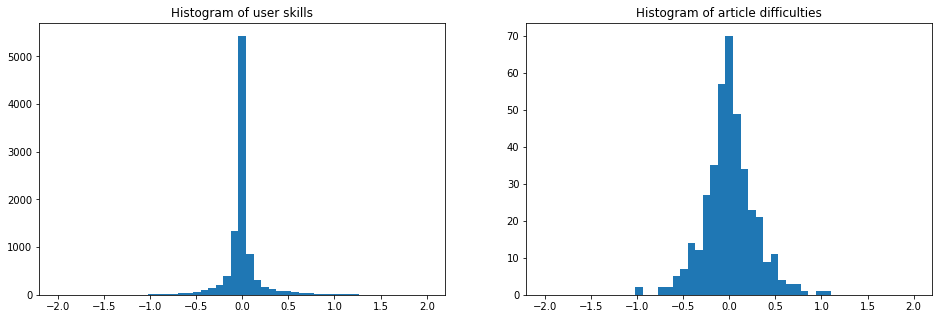

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5), sharex=True)

ax1.hist(skills, bins=np.linspace(-2, 2, num=50))
ax1.set_title("Histogram of user skills")

ax2.hist(difficulties, bins=np.linspace(-2, 2, num=50))
ax2.set_title("Histogram of article difficulties")

### Histograms of labels

Text(0.5,1,'Histogram of model estimates')

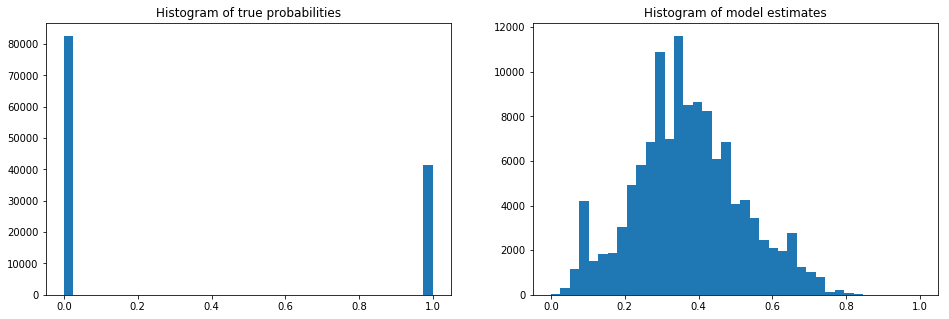

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5), sharex=True)

ax1.hist(test[2], bins=np.linspace(0, 1, num=40))
ax1.set_title("Histogram of true probabilities")

ax2.hist(probs, bins=np.linspace(0, 1, num=40))
ax2.set_title("Histogram of model estimates")

In [13]:
saver = tf.train.Saver()
saver.save(session, "../trained-models/linux/basic.ckpt")

with open('../data/linux-basic-probs.txt', 'w') as f:
    f.writelines(['{:.20f}\n'.format(p) for p in probs[0]])